<a href="https://colab.research.google.com/github/sabih411/CSE587-Project/blob/main/CSE587_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading Libraries

In [ ]:
import torchaudio
import os 
import torch 
import torch.nn as nn 
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np 

#Mounting Drive

In [ ]:
from google.colab import drive  
drive.mount('/content/drive') 

Mounted at /content/drive


#The Loss Functions and Reverse-Set Function


**Loss Function**


---



*   Character Error Rate (CER)
*   Word Error Rate (WER)

**Reverse Functions**


---


*   data_processing_normal (to handle undististurbed audio)
*   data_processing_LTR (to handle locally-time reversed audio)
*   data_processing_probabilistic25 ( to handle probabilistic-25 Reverse set)
*   data_processing_50p (to handle Reverse set-50%)







In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)

def _levenshtein_distance(ref, hyp):

    m = len(ref)
    n = len(hyp)

    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    distance = np.zeros((2, n + 1), dtype=np.int32)

    for j in range(0,n + 1):
        distance[0][j] = j

    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):

    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):

    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):

    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):

    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer
 
class TextTransform:
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
    
        self.index_map[1] = ' '

    def text_to_int(self, text):
        int_sequence = []
        for c in text:      
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')


train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()
import matplotlib.pyplot as plt
def data_processing_normal(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)

    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


def data_processing_LTR(data, data_type="train"):
    spectrograms = []
    labels = [] 
    input_lengths = []
    label_lengths = []
    for (waveform, ss, utterance, _, _, _) in data:
        #torchaudio.save('hey4.wav', waveform,ss)
        Fs = ss  
        segment_length = int(Fs * 0.02)
        num_segments = waveform.shape[-1] // segment_length
        segments = torch.chunk(waveform,num_segments , dim=-1)
        segment_list=list(segments)
        for i in range(len(segment_list)):
                    segment_list[i] = torch.flip(segment_list[i], dims=(-1,))
        segments=tuple(segment_list)
        reversed_waveform = torch.cat(segments, dim=-1)
        if reversed_waveform.shape[-1] != waveform.shape[-1]:
                    last_segment = waveform[:, -segment_length:]
                    reversed_waveform = torch.cat([reversed_waveform, last_segment], dim=-1)
                #torchaudio.save('hey4.wav', reversed_waveform,Fs)

        if data_type == 'train':
            spec = train_audio_transforms(reversed_waveform).squeeze(0).transpose(0, 1)  
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))
        
    
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

def data_processing_probabilistic25(data, data_type="train"):
    import matplotlib.pyplot as plt
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
            
        waveform_length = waveform.shape[-1]
        num_segments = 4  
        segment_length = waveform_length // num_segments
        for i in range(num_segments):
                start = i * segment_length
                end = start + segment_length
                if torch.rand(1) < 0.5: 
                    waveform[:, start:end] = torch.flip(waveform[:, start:end], dims=[-1])

        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
       
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


def data_processing_50p(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        
        half_len = waveform.shape[-1] // 2
        waveform = torch.cat([waveform[:, half_len:], waveform[:, :half_len]], dim=-1)
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)

    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue 
				decode.append(index.item())
		decodes.append(text_transform.int_to_text(decode))
	return decodes, targets

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


#Realizing the Different Reverse Sets 

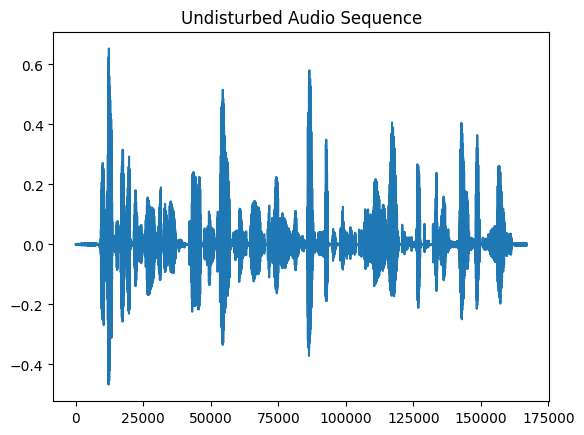

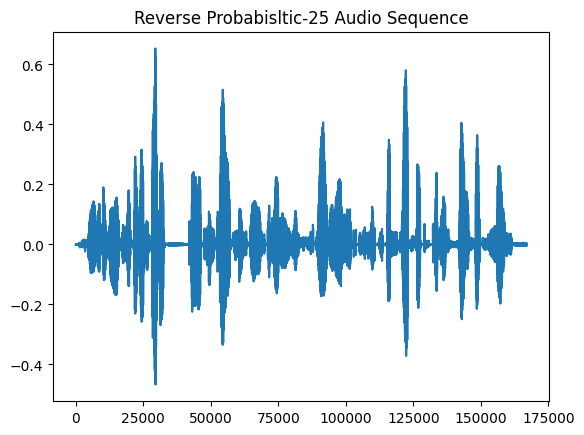

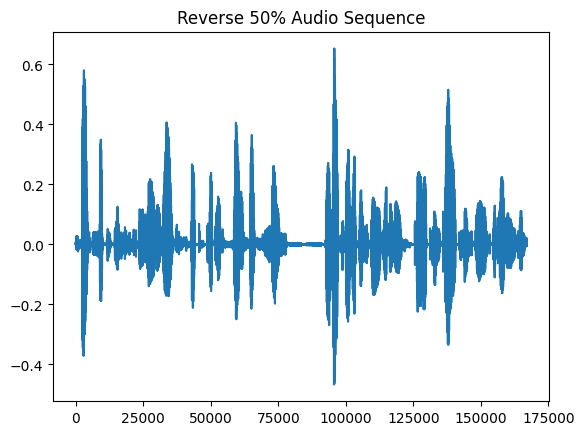

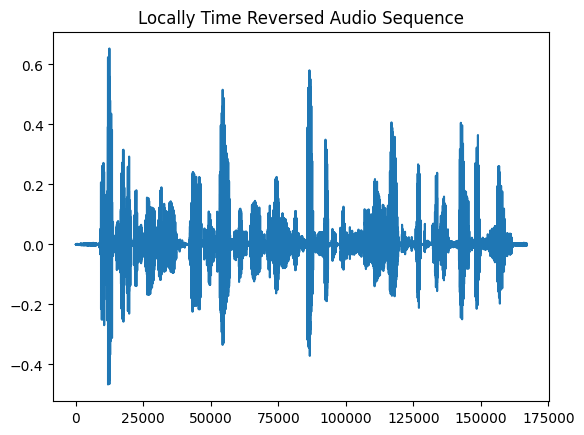

In [ ]:
waveform, sample_rate = torchaudio.load('/content/test.wav')
plt.plot(waveform.t().numpy())
plt.title("Undisturbed Audio Sequence")
plt.show()

reversed_waveform=waveform.clone()
waveform_length = waveform.shape[-1]
num_segments = 4  
segment_length = waveform_length // num_segments
for i in range(num_segments):
        start = i * segment_length
        end = start + segment_length
        if torch.rand(1) < 0.5: 
                reversed_waveform[:, start:end] = torch.flip(waveform[:, start:end], dims=[-1])
plt.plot(reversed_waveform.t().numpy())
plt.title("Reverse Probabisltic-25 Audio Sequence")
plt.show()

half_len = waveform.shape[-1] // 2
reversed_waveform = torch.cat([waveform[:, half_len:], waveform[:, :half_len]], dim=-1)
plt.plot(reversed_waveform.t().numpy())
plt.title("Reverse 50% Audio Sequence")
plt.show()

Fs = sample_rate
segment_length = int(Fs * 0.02)
num_segments = waveform.shape[-1] // segment_length
segments = torch.chunk(waveform,num_segments , dim=-1)
segment_list=list(segments)
for i in range(len(segment_list)):
                    segment_list[i] = torch.flip(segment_list[i], dims=(-1,))
segments=tuple(segment_list)
reversed_waveform = torch.cat(segments, dim=-1)
if reversed_waveform.shape[-1] != waveform.shape[-1]:
                    last_segment = waveform[:, -segment_length:]
                    reversed_waveform = torch.cat([reversed_waveform, last_segment], dim=-1)
plt.plot(reversed_waveform.t().numpy())
plt.title("Locally Time Reversed Audio Sequence")
plt.show()


#Spectrogram Visual

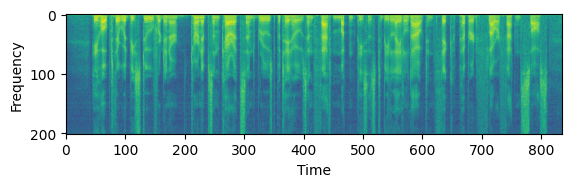

In [ ]:
waveform, sample_rate = torchaudio.load('/content/test.wav')
specgram = torchaudio.transforms.Spectrogram()(waveform)
log_specgram = torchaudio.transforms.AmplitudeToDB()(specgram)
plt.figure()
plt.imshow(log_specgram.squeeze(0).numpy(), cmap='viridis')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

#Model Deep Speech-2

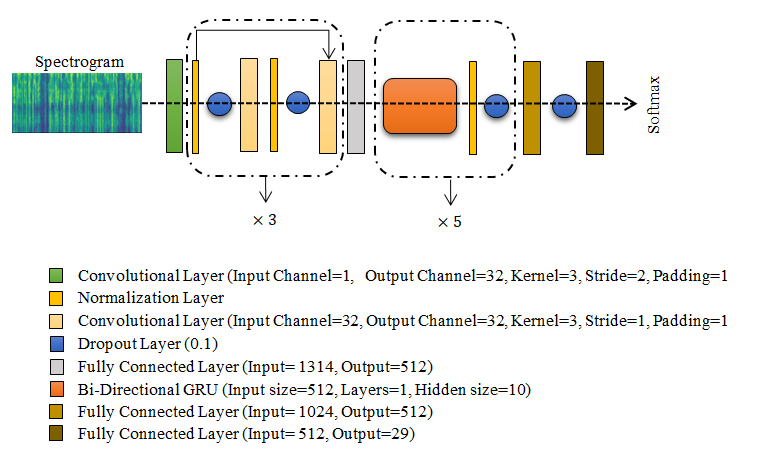

In [ ]:
class CNNLayerNorm(nn.Module):
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        x = x.transpose(2, 3).contiguous()
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() 
class ResidualCNN(nn.Module):

    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x 
        
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=1, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2) 

        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim), 
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        ) 

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  
        x = x.transpose(1, 2) 
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x 

##Train-Test Functions

In [ ]:
class IterMeter(object):
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter):
    model.train()
    data_len = len(train_loader.dataset)
    
    for batch_idx, _data in enumerate(train_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            optimizer.zero_grad()

            output = model(spectrograms)  
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) 

            loss = criterion(output, labels, input_lengths, label_lengths)
            loss.backward()

            optimizer.step()
            scheduler.step()
            iter_meter.step()
            if batch_idx % 100 == 0 or batch_idx == data_len:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(spectrograms), data_len,
                    100. * batch_idx / len(train_loader), loss.item()))
                training_stats.append(100. * batch_idx / len(train_loader), loss.item())
    training_stats=np.array(training_stats)
    np.save("/content/drive/MyDrive/training_stats/normal.npy",training_stats)

def test(model, device, test_loader, criterion, epoch, iter_meter):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    
    with torch.no_grad():
            for i, _data in enumerate(test_loader):
                spectrograms, labels, input_lengths, label_lengths = _data 
                spectrograms, labels = spectrograms.to(device), labels.to(device)
              
                output = model(spectrograms)  
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0, 1) 

                loss = criterion(output, labels, input_lengths, label_lengths)
                test_loss += loss.item() / len(test_loader)

                decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
               
                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))

def save_checkpoint(state,filename):
  filename="/content/drive/MyDrive/reverse_20/my_checkpoint_epoch_"+str(filename)+"_.pth.tar"


  print("=>saving checkpoint")
  torch.save(state,filename)

def load_checkpoint(model,optimizer,checkpoint):
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  

def main(learning_rate=5e-4, batch_size=20, epochs=10,train_url="train-clean-100", test_url="test-clean"):

    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    if not os.path.isdir("./data"):
        os.makedirs("./data")
    
    train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=train_url, download=True)
    test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)
  
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    print("done and before test load")
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing_LTR(x, 'valid'),
                                **kwargs)
    

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)

    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))
    
    
    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=28).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')
    
    iter_meter = IterMeter() 
    global training_stats
    training_stats=[]
    load_checkpoint(model,optimizer,torch.load("/content/drive/MyDrive/point_files/reverse_20/my_checkpoint_epoch_11_.pth.tar"))
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter)
        test(model, device, test_loader, criterion, epoch, iter_meter)
        checkpoint={'state_dict':model.state_dict(),'optimizer':optimizer.state_dict()}
        save_checkpoint(checkpoint,epoch+8) 

## Training of Undisturbed Speech Sequence

In [ ]:
import sys
learning_rate = 5e-4
batch_size = 10
epochs = 10
libri_train_set = "train-clean-100" 
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

## Training of Locall Time Reversed Audio Sequence

In [ ]:
import sys
learning_rate = 5e-4
batch_size = 10
epochs = 10
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

before libri load


100%|██████████| 5.95G/5.95G [07:32<00:00, 14.1MB/s]
100%|██████████| 331M/331M [00:25<00:00, 13.4MB/s]


done
before train load
done and before test load
done
SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1)

**The above training continues below**

In [ ]:
import sys
learning_rate = 5e-4
batch_size = 10
epochs = 3
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

before libri load


100%|██████████| 5.95G/5.95G [05:12<00:00, 20.4MB/s]
100%|██████████| 331M/331M [00:18<00:00, 18.5MB/s]


done
before train load
done and before test load
done
SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1)

##Inference

### Inferring Locally Time Reversed Model


*   Load the best checkpoint file in Train-Test Section
path--> ./weights/point_files/reverse_20/my_checkpoint_epoch_11_.pth.tar



*   **CTC: 0.5429 | CER:0.15746 |  WER:0.4612**



In [ ]:
import sys
learning_rate = 5e-4
batch_size = 32
epochs = 1
libri_train_set = "train-clean-100" 
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

100%|██████████| 331M/331M [00:30<00:00, 11.2MB/s]


SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

### Inferring Undisturbed Speech Sequence Model 
*   Load the best checkpoint file in Train-Test Section
path--> ./weights/point_files/check_point_files/my_checkpoint_epoch_10_.pth.tar
*   **CTC: 0.4871 | CER:0.140907 |  WER:0.4302**

In [ ]:
import sys
learning_rate = 5e-4 
batch_size = 32
epochs = 1
libri_train_set = "train-clean-100" 
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

##Unstable-Training of Probabilistic-25 Reverse-set

In [ ]:
import sys
learning_rate = 5e-4
batch_size = 10
epochs = 10
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

before libri load


100%|██████████| 5.95G/5.95G [07:20<00:00, 14.5MB/s]
100%|██████████| 331M/331M [00:27<00:00, 12.8MB/s]


done
before train load
done and before test load
done
SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1)

##Unstable-Training of Reverse set 50%

In [ ]:
import sys
learning_rate = 5e-4
batch_size = 10
epochs = 10
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

before libri load


100%|██████████| 5.95G/5.95G [04:02<00:00, 26.4MB/s]
100%|██████████| 331M/331M [00:14<00:00, 24.7MB/s]


done
before train load
done and before test load
done
SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1)

KeyboardInterrupt: ignored

#The Pipeline (Ensemble Model)
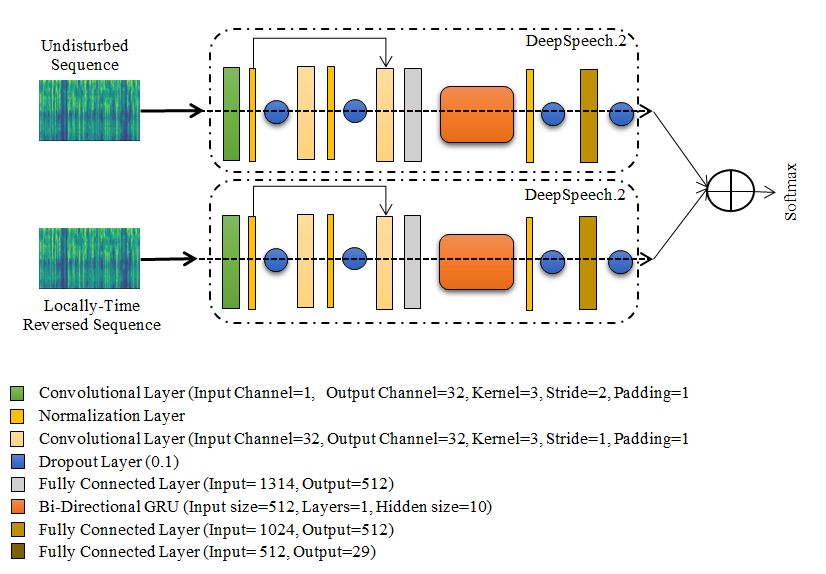

In [ ]:
class CNNLayerNorm(nn.Module):
   
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        
        x = x.transpose(2, 3).contiguous() 
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()

class ResidualCNN(nn.Module):

    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x 
        
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):


    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=1, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, 29)
        ) 

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3]) 
        x = x.transpose(1, 2) 
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x 

class CombinedModel(torch.nn.Module):
    def __init__(self,hparams):
        super(CombinedModel, self).__init__()
        self.submodel1= SpeechRecognitionModel(hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
                                               hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout'])
        self.submodel2= SpeechRecognitionModel(hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
                                               hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout'])
      
        

    def forward(self, input1, input2):
        output1 = self.submodel1(input1)
        output2 = self.submodel2(input2)
        combined_output = output1+output2
        return combined_output

##Train-Test Functions

In [ ]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader1,train_loader2, criterion, optimizer, scheduler, epoch, iter_meter):
    model.train()
    data_len = len(train_loader1.dataset)
    combined_loader=zip(train_loader1,train_loader2)
    for batch_idx, (data1,data2) in enumerate(combined_loader):
            spectrograms1, labels, input_lengths, label_lengths = data1
            spectrograms2, labels, input_lengths, label_lengths = data2
            spectrograms1, labels = spectrograms1.to(device), labels.to(device)
            spectrograms2 = spectrograms2.to(device)
            
            optimizer.zero_grad()
            #print("spectrogram shape",spectrograms1.shape)
            output = model(spectrograms1,spectrograms2)  
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) 

            loss = criterion(output, labels, input_lengths, label_lengths)
            loss.backward()

            optimizer.step()
            scheduler.step()
            iter_meter.step()
            if batch_idx % 100 == 0 or batch_idx == data_len:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(spectrograms1), data_len,
                    100. * batch_idx / len(train_loader1), loss.item()))
                training_stats.append(100. * batch_idx / len(train_loader1), loss.item())
    training_stats=np.array(training_stats)
    np.save("/content/drive/MyDrive/training_stats/combined.npy",training_stats)

def test(model, device, test_loader1,test_loader2, criterion, epoch, iter_meter):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    combined_loader=zip(test_loader1,test_loader2)
    with torch.no_grad():
            for i, (data1,data2) in enumerate(combined_loader):
                spectrograms1, labels, input_lengths, label_lengths = data1
                spectrograms2, labels, input_lengths, label_lengths = data2
                spectrograms1, labels = spectrograms1.to(device), labels.to(device)
                spectrograms2 = spectrograms2.to(device)
                #print("spectrogram shape",spectrograms.shape)
                output = model(spectrograms1,spectrograms2)  
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0, 1) 

                loss = criterion(output, labels, input_lengths, label_lengths)
                test_loss += loss.item() / len(test_loader1)

                decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
                #print("Original:",decoded_targets,"\nPredicted:",decoded_preds)  // Uncomment this to see predicted and original output
                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))

def save_checkpoint(state,filename):
  filename="/content/drive/MyDrive/point_files/combined/my_checkpoint_epoch_"+str(filename)+"_.pth.tar"
  

  print("=>saving checkpoint")
  torch.save(state,filename)

def load_checkpoint(model,optimizer,checkpoint):
  model.load_state_dict(checkpoint['state_dict'])
  
  

def main(learning_rate=5e-4, batch_size=20, epochs=10,train_url="train-clean-100", test_url="test-clean"):

    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    #seed = 24567
    seed=12345
    torch.manual_seed(seed)

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    if not os.path.isdir("./data"):
        os.makedirs("./data")
    
    train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=train_url, download=False)
    test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)
    
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
  
    train_loader1 = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing_normal(x, 'train'),
                                worker_init_fn=lambda x: torch.manual_seed(seed),
                                **kwargs)
    train_loader2 = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing_LTR(x, 'train'),
                                worker_init_fn=lambda x: torch.manual_seed(seed),
                                **kwargs)
    
    test_loader1 = data.DataLoader(dataset=test_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing_normal(x, 'valid'),
                                worker_init_fn=lambda x: torch.manual_seed(seed),
                                **kwargs) 
    test_loader2 = data.DataLoader(dataset=test_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing_LTR(x, 'valid'),
                                worker_init_fn=lambda x: torch.manual_seed(seed),
                                **kwargs) 
    model=CombinedModel(hparams).to(device)
    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=28).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                            steps_per_epoch=int(len(train_loader1)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')
    
    #Comment the two lines below if not Fine-tuning
    load_checkpoint(model.submodel1,optimizer,torch.load("/content/drive/MyDrive/point_files/check_point_files/my_checkpoint_epoch_10_.pth.tar"))
    load_checkpoint(model.submodel2,optimizer,torch.load("/content/drive/MyDrive/point_files/reverse_20/my_checkpoint_epoch_8_.pth.tar"))
    

    for param in model.submodel1.parameters():
       param.requires_grad=False
    for param in model.submodel2.parameters():
       param.requires_grad=False 
    for param in model.submodel1.classifier.parameters(): 
       param.requires_grad=True
    for param in model.submodel2.classifier.parameters():
       param.requires_grad=True

    load_checkpoint(model,optimizer,torch.load("/content/drive/MyDrive/point_files/combined/my_checkpoint_epoch_1_.pth.tar"))
    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))
    
    global training_stats
    training_stats=[]    

    
    iter_meter = IterMeter()
    for epoch in range(1, epochs + 1):
      
        train(model, device, train_loader1,train_loader2, criterion, optimizer, scheduler, epoch, iter_meter)
        test(model, device, test_loader1,test_loader2 ,criterion, epoch, iter_meter)
        checkpoint={'state_dict':model.state_dict(),'optimizer':optimizer.state_dict()}
        save_checkpoint(checkpoint,epoch)

##Training of Emsemble Model

Since we were fine-tuning the emsemble model, therefore the results after first two epochs are considered to be optical. Training further leads to no further convergence. 



In [ ]:
import sys
learning_rate = 5e-4
batch_size = 10
epochs = 10 
libri_train_set = "train-clean-100" 
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

CombinedModel(
  (submodel1): SpeechRecognitionModel(
    (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (rescnn_layers): Sequential(
      (0): ResidualCNN(
        (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (layer_norm1): CNNLayerNorm(
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (layer_norm2): CNNLayerNorm(
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
      )
      (1): ResidualCNN(
        (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
     

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff770cc2950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff770cc2950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 1 [1000/28539 (4%)]	Loss: 0.471597
Train Epoch: 1 [2000/28539 (7%)]	Loss: 0.387688
Train Epoch: 1 [3000/28539 (11%)]	Loss: 0.290237
Train Epoch: 1 [4000/28539 (14%)]	Loss: 0.347436
Train Epoch: 1 [5000/28539 (18%)]	Loss: 0.184268
Train Epoch: 1 [6000/28539 (21%)]	Loss: 0.367550
Train Epoch: 1 [7000/28539 (25%)]	Loss: 0.228805
Train Epoch: 1 [8000/28539 (28%)]	Loss: 0.323212
Train Epoch: 1 [9000/28539 (32%)]	Loss: 0.308080
Train Epoch: 1 [10000/28539 (35%)]	Loss: 0.502174
Train Epoch: 1 [11000/28539 (39%)]	Loss: 0.476221
Train Epoch: 1 [12000/28539 (42%)]	Loss: 0.246615
Train Epoch: 1 [13000/28539 (46%)]	Loss: 0.393438
Train Epoch: 1 [14000/28539 (49%)]	Loss: 0.340379
Train Epoch: 1 [15000/28539 (53%)]	Loss: 0.453355
Train Epoch: 1 [16000/28539 (56%)]	Loss: 0.292392
Train Epoch: 1 [17000/28539 (60%)]	Loss: 0.384375
Train Epoch: 1 [18000/28539 (63%)]	Loss: 0.309058
Train Epoch: 1 [19000/28539 (67%)]	Loss: 0.255982
Train Epoch: 1 [20000/28539 (70%)]	Loss: 0.401884
Train Epoch

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff770cc2950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff770cc2950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 2 [1000/28539 (4%)]	Loss: 0.412124
Train Epoch: 2 [2000/28539 (7%)]	Loss: 0.356710
Train Epoch: 2 [3000/28539 (11%)]	Loss: 0.275087
Train Epoch: 2 [4000/28539 (14%)]	Loss: 0.338123
Train Epoch: 2 [5000/28539 (18%)]	Loss: 0.170767
Train Epoch: 2 [6000/28539 (21%)]	Loss: 0.369757
Train Epoch: 2 [7000/28539 (25%)]	Loss: 0.210583
Train Epoch: 2 [8000/28539 (28%)]	Loss: 0.307342
Train Epoch: 2 [9000/28539 (32%)]	Loss: 0.329314
Train Epoch: 2 [10000/28539 (35%)]	Loss: 0.487772
Train Epoch: 2 [11000/28539 (39%)]	Loss: 0.477440
Train Epoch: 2 [12000/28539 (42%)]	Loss: 0.255335
Train Epoch: 2 [13000/28539 (46%)]	Loss: 0.383300
Train Epoch: 2 [14000/28539 (49%)]	Loss: 0.343387
Train Epoch: 2 [15000/28539 (53%)]	Loss: 0.434216
Train Epoch: 2 [16000/28539 (56%)]	Loss: 0.287618
Train Epoch: 2 [17000/28539 (60%)]	Loss: 0.400149
Train Epoch: 2 [18000/28539 (63%)]	Loss: 0.309848
Train Epoch: 2 [19000/28539 (67%)]	Loss: 0.258505
Train Epoch: 2 [20000/28539 (70%)]	Loss: 0.416676
Train Epoch

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff770cc2950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff770cc2950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 3 [1000/28539 (4%)]	Loss: 0.400386
Train Epoch: 3 [2000/28539 (7%)]	Loss: 0.378989
Train Epoch: 3 [3000/28539 (11%)]	Loss: 0.264453
Train Epoch: 3 [4000/28539 (14%)]	Loss: 0.335202
Train Epoch: 3 [5000/28539 (18%)]	Loss: 0.169432
Train Epoch: 3 [6000/28539 (21%)]	Loss: 0.384613
Train Epoch: 3 [7000/28539 (25%)]	Loss: 0.214840
Train Epoch: 3 [8000/28539 (28%)]	Loss: 0.311709
Train Epoch: 3 [9000/28539 (32%)]	Loss: 0.335610
Train Epoch: 3 [10000/28539 (35%)]	Loss: 0.488842
Train Epoch: 3 [11000/28539 (39%)]	Loss: 0.476813
Train Epoch: 3 [12000/28539 (42%)]	Loss: 0.247901
Train Epoch: 3 [13000/28539 (46%)]	Loss: 0.396673
Train Epoch: 3 [14000/28539 (49%)]	Loss: 0.330528
Train Epoch: 3 [15000/28539 (53%)]	Loss: 0.466041
Train Epoch: 3 [16000/28539 (56%)]	Loss: 0.281371
Train Epoch: 3 [17000/28539 (60%)]	Loss: 0.413007
Train Epoch: 3 [18000/28539 (63%)]	Loss: 0.321969
Train Epoch: 3 [19000/28539 (67%)]	Loss: 0.248013
Train Epoch: 3 [20000/28539 (70%)]	Loss: 0.419485
Train Epoch

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff770cc2950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff770cc2950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

KeyboardInterrupt: ignored

## Inferring The Ensemble Model
*   Load the best checkpoint file in Train-Test Section
path--> ./weights/point_files/combined/my_checkpoint_epoch_1_.pth.tar

*   **CTC: 0.4967 | CER:0.136887 |  WER:0.4189**

In [ ]:
import sys
learning_rate = 5e-4
batch_size = 32
epochs = 1 
libri_train_set = "train-clean-100" 
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

CombinedModel(
  (submodel1): SpeechRecognitionModel(
    (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (rescnn_layers): Sequential(
      (0): ResidualCNN(
        (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (layer_norm1): CNNLayerNorm(
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (layer_norm2): CNNLayerNorm(
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
      )
      (1): ResidualCNN(
        (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
     

#Plotting
The function below utilizes the pre-saved numpy array of the training stats!

<ipython-input-5-5271f4eca592>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


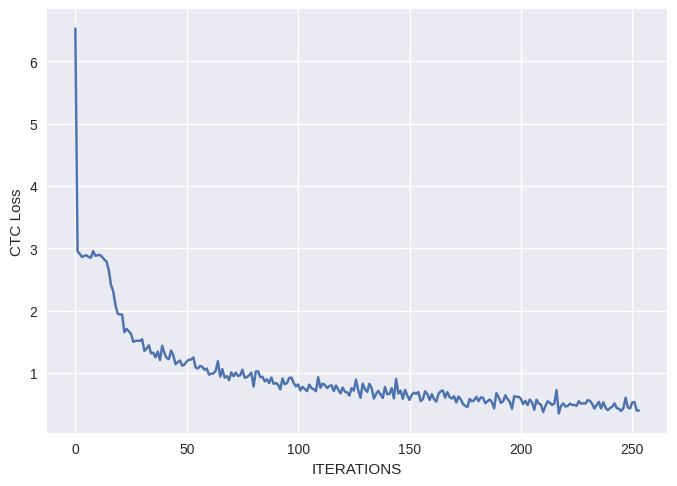

In [ ]:
import matplotlib.pyplot as plt
y=np.load("/content/drive/MyDrive/training_stats/normal.npy")
plt.xlabel("ITERATIONS")
plt.ylabel("CTC Loss")
plt.style.use("seaborn")
plt.plot(y)
plt.show()

<ipython-input-6-a54320bd757b>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


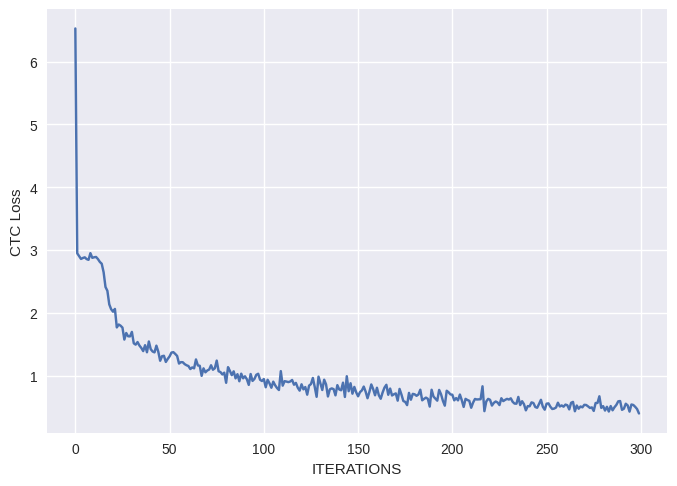

In [ ]:
y=np.load("/content/drive/MyDrive/training_stats/LTR.npy")
plt.xlabel("ITERATIONS")
plt.ylabel("CTC Loss")
plt.style.use("seaborn")
plt.plot(y)
plt.show()

<ipython-input-7-6f0556a53ff0>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


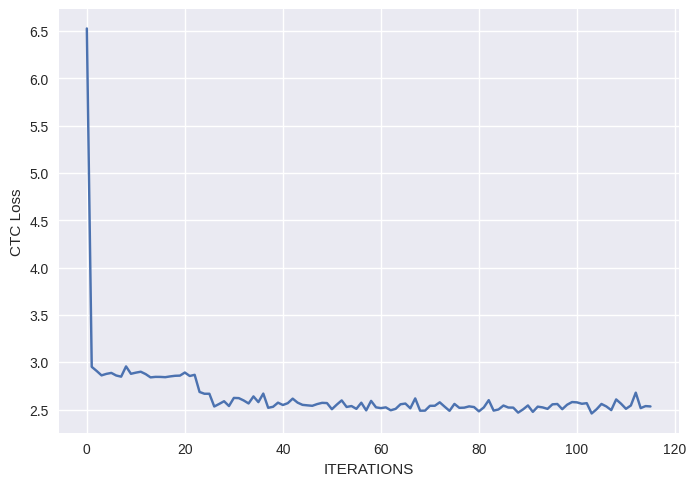

In [ ]:
y=np.load("/content/drive/MyDrive/training_stats/5050.npy")
plt.xlabel("ITERATIONS")
plt.ylabel("CTC Loss")
plt.style.use("seaborn")
plt.plot(y)
plt.show()

<ipython-input-8-cda430dc205c>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


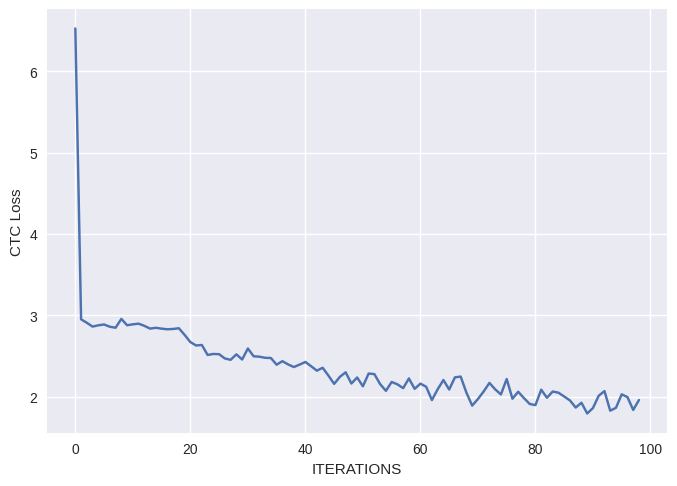

In [ ]:
y=np.load("/content/drive/MyDrive/training_stats/probability25.npy")
plt.xlabel("ITERATIONS")
plt.ylabel("CTC Loss")
plt.style.use("seaborn")
plt.plot(y)
plt.show()

<ipython-input-16-7c3be56e2032>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


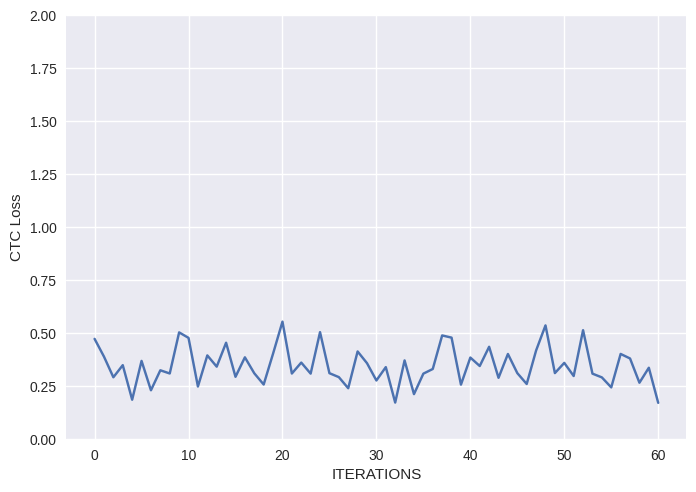

In [ ]:
y=np.load("/content/drive/MyDrive/training_stats/combined.npy")
plt.xlabel("ITERATIONS")
plt.ylabel("CTC Loss")
plt.style.use("seaborn")
plt.ylim([0, 2])
plt.plot(y)
plt.show()

#Helper Function


*   Can be Used to increase the Training Speed by avoiding the hastle of tranforming waveforms on each iteration.
*   Code below shows an example of pre-saving the reverse-50% set loaded from the PyTorch libray LibriSpeech
*   Pre-install the library (**pydub**) to run this!




In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from re import sub
import glob
import wave
from pydub import AudioSegment
for folder_numbers in glob.glob('/content/data/LibriSpeech/train-clean-100/*'):
  for sub_folders in glob.glob(folder_numbers+"/*"):
    for sub_sub in glob.glob(sub_folders+"/*"):
    
      if(sub_sub[-4:]=="flac"):
      #if(sub_sub=="/content/data/LibriSpeech/test-clean/1188/133604/1188-133604-0006.flac"):
        
        #get flac and convert to WAV
        path_flac=sub_sub
        flac_file=sub_sub 
        wav_file = path_flac[:-4]+"wav"
        path_wav=wav_file
        audio = AudioSegment.from_file(flac_file, format="flac")
        audio.export(wav_file, format="wav")
        #delete the flac
        os.remove(flac_file)

        print(path_wav)
        #get wav and reverse
        infile = path_wav
        path_new=path_wav[:-4]+"new.wav"
        outfile = path_new
        with wave.open(infile, 'rb') as input_file:
            params = input_file.getparams()
            audio_data = input_file.readframes(params.nframes)
            half_point = len(audio_data) // 2 
            first_half = audio_data[:half_point]
            second_half = audio_data[half_point:] 
            modified_audio_data = second_half + first_half 
            with wave.open(outfile, 'wb') as output_file:
                output_file.setparams(params) 
                output_file.writeframes(modified_audio_data)
        
        #remove the unreversed wave
        os.remove(infile)
        #convert new wav to flac
        wav_file = str(path_new)
        flac_file = str(path_flac)
        audio = AudioSegment.from_wav(wav_file)
        audio.export(flac_file, format="flac")
        os.remove (wav_file)



Streaming output truncated to the last 5000 lines.
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0046.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0059.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0060.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0025.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0006.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0076.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0040.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0070.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0024.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0052.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0077.wav
/content/data/LibriSpeech/train-clean-100/6880/216547/6880-216547-0067.wav
/content/data/LibriSpeech/train-clean-100/6880/21